<a href="https://colab.research.google.com/github/rizqyjoe/Facial_Expression_Recognition_CNN_VGG16/blob/main/Model%203/3_85%25_Acc_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_spl it = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Dataset/FER2013/images/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 23068 images belonging to 7 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Dataset/FER2013/images/validation',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1411 images belonging to 7 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),
                                         include_top=False,
                                         weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

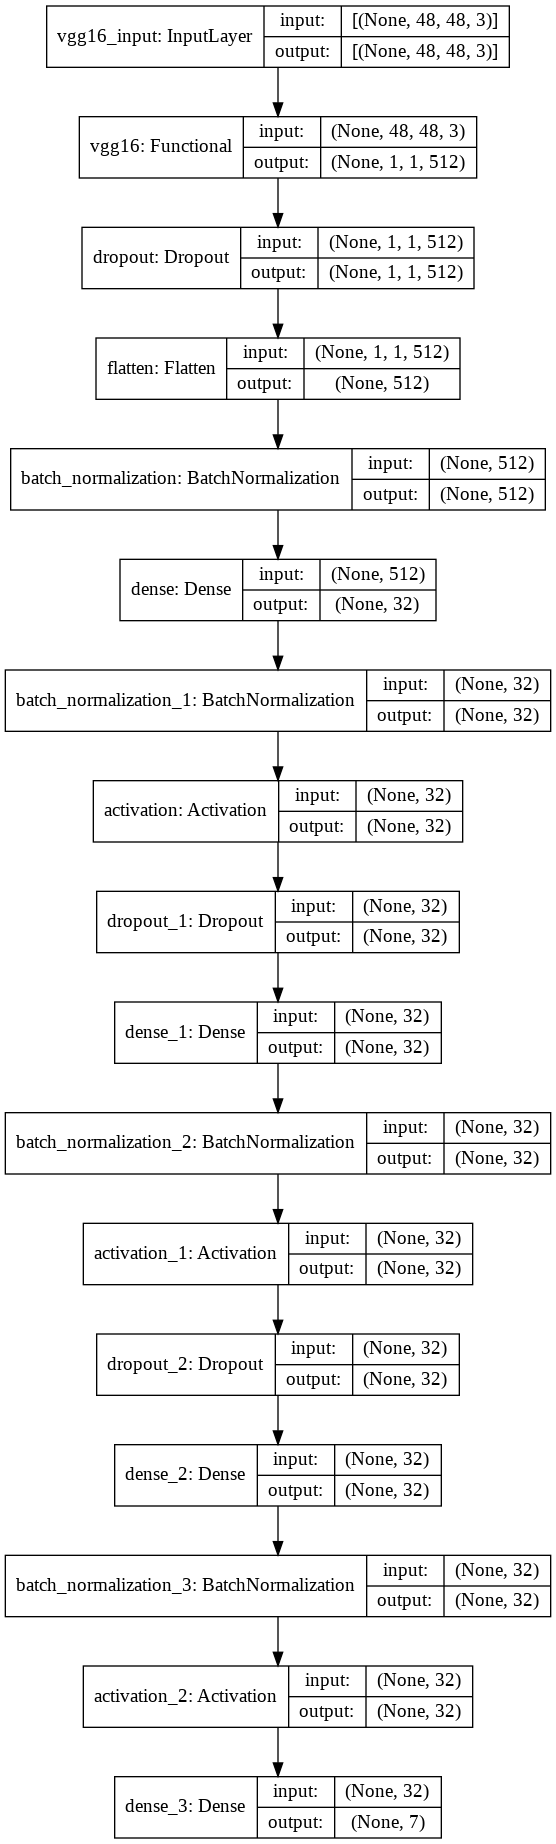

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='vgg.png', show_shapes=True,show_layer_names=True)
Image(filename='vgg.png') 

In [11]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.50, 
                        min_lr = 1e-10)

mcp = ModelCheckpoint('Model3_VGG16FT_Adam0.001.h5')

es = EarlyStopping(verbose=1, 
                   patience=20)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=METRICS)

In [15]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 25,
                  verbose = 1,
                  callbacks=[lrd,mcp,es])

Epoch 1/25
361/361 [==============================] - 6353s 17s/step - loss: 2.0170 - accuracy: 0.8532 - precision: 0.1607 - recall: 0.0060 - auc: 0.5686 - f1_score: 0.0112 - val_loss: 1.8361 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6353 - val_f1_score: 0.0000e+00
Epoch 2/25
361/361 [==============================] - 67s 185ms/step - loss: 1.8426 - accuracy: 0.8569 - precision: 0.2809 - recall: 0.0012 - auc: 0.6298 - f1_score: 0.0023 - val_loss: 1.8393 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6393 - val_f1_score: 0.0000e+00
Epoch 3/25
361/361 [==============================] - 66s 183ms/step - loss: 1.8167 - accuracy: 0.8569 - precision: 0.4339 - recall: 0.0062 - auc: 0.6445 - f1_score: 0.0120 - val_loss: 1.7727 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 7.0872e-04 - val_auc: 0.6804 - val_f1_score: 0.0013
Epoch 4/25
361/361 [==============================] - 64s 178ms/step 

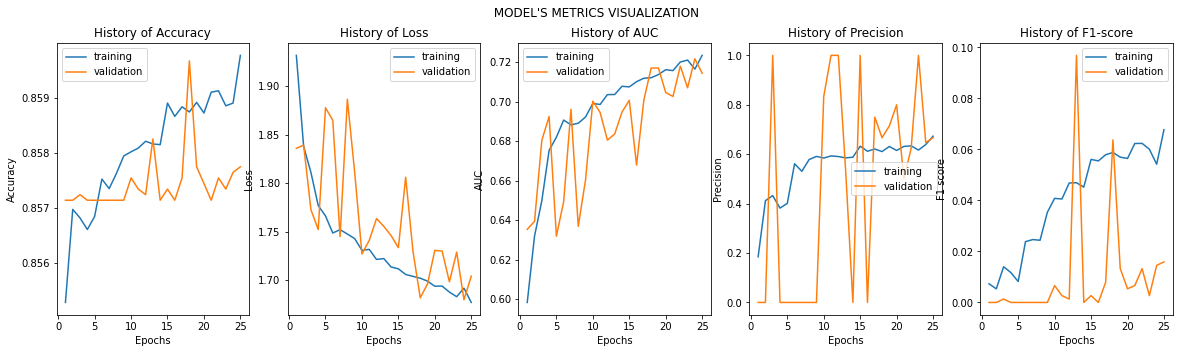

In [17]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )